###   1. Hypothesis: We can derive an indication of AADT for local government roads from the Sample value in                      HERE historical data
-	Due by 6 November
-	New Austroads Guide to Temporary Traffic Management have a criteria to categorise state and local roads
-	Indication of AADT for local government roads (let’s say bands by 1000s) is desirable
-	Can the sample value in HERE historical data give us an indication of AADT?
-	Suggested approach/PoC – try to derive values from HERE by using a known AADT dataset

### Reliability of HERE -   Variance and Bias

The data as provided by HERE is a sample selection - how reflective is this of the overall populations distribution? 

1) Variance  (measure how far as set of radom numbers (our select sample) from its mean).
- Look at hourly, daily and seasonal trends/variations from here extracted links

2) Bias (tendency of a measurement process to over-or under-estimate statistics)
- Is the sample sample selected have systematic bias?
- Are there  privacy and applied aggregated data?

3) Sample Statistics (metrics and parameters)
- what are the error when we scale HERE sample if using aadt from loops are used? 

Approaches
- 1) Compare a High Count sites & a low Count sites then the sites below the median.
- 2) Autotmate approach to deliver analyisis against all sites.

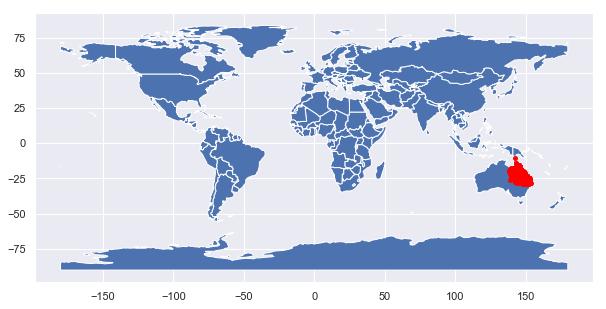

In [1964]:
#### Load AADT 2018 data from Open data
import pandas as pd 
#Annual Average Daily Traffic (AADT) is the number of vehicles passing a point on a road in a 24 hour period averaged over a calendar year. This figure for short term counts is seasonally adjusted.
data_repo = 'here_historic_links/'
aadt_2018=pd.read_csv(data_repo+'trafficcensus2018.csv') #load from https://www.data.qld.gov.au/dataset/traffic-census-for-the-queensland-state-declared-road-network/resource/4b1011ec-61f1-4818-b44c-edfe15828a4e
aadt_2018.head()
aadt_2018.set_index('SITE_ID') 

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
geometry = [Point(xy) for xy in zip(aadt_2018['LONGITUDE'],aadt_2018['LATITUDE'])]
aadt_2018_gdf = GeoDataFrame(aadt_2018, geometry=geometry)
aadt_2018_gdf.set_index('SITE_ID') 

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
aadt_2018_gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

Text(0, 0.5, 'Frequency')

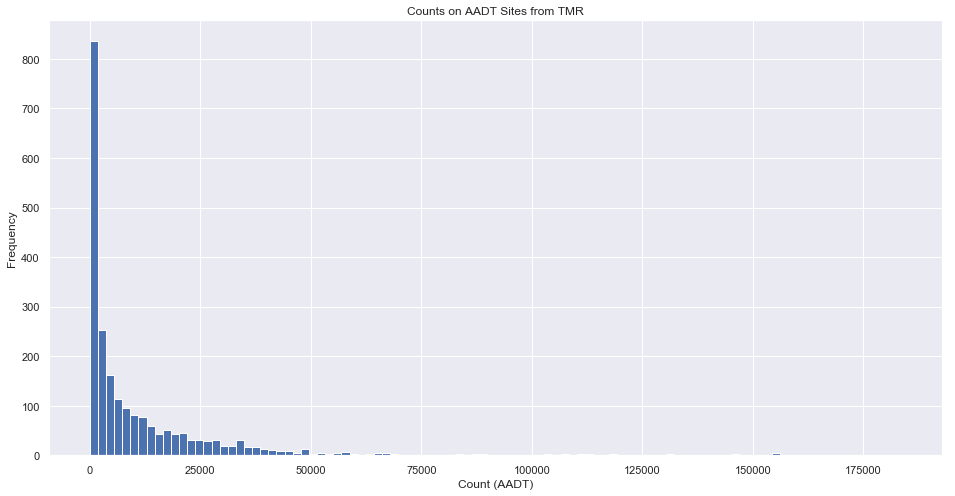

In [1965]:
aadt_2018_gdf.hist('AADT', bins= 100)
plt.title('Counts on AADT Sites from TMR')
plt.xlabel('Count (AADT)')
plt.ylabel('Frequency')

## Variance

##### Check minimum criteria. A sites with high aadt count.
Site 135970 on Pine River Bridge - with a count of 77,905 AADT.

HERE route link selected historic 2018/01/01 - 2018/12/31 to match with addt site.

In [1966]:
#Sort top aadt counts
aadt_2018_gdf_sort= aadt_2018_gdf.sort_values(by='AADT', ascending=False)
#aadt_2018_gdf_sort[0:10]
site_selected = aadt_2018_gdf_sort[3:4] # Site 135970 on Pine River Bridge selected as candidate

#Display location
lons= site_selected['LONGITUDE'].values.tolist()
lats= site_selected['LATITUDE'].values.tolist()
fig = plt.figure(figsize=(8, 8))    #This is missing in your code.
plt.plot(lons, lats, 'b.', markersize = 30)
mplleaflet.display(fig=fig,)

Text(0, 0.5, 'Frequency')

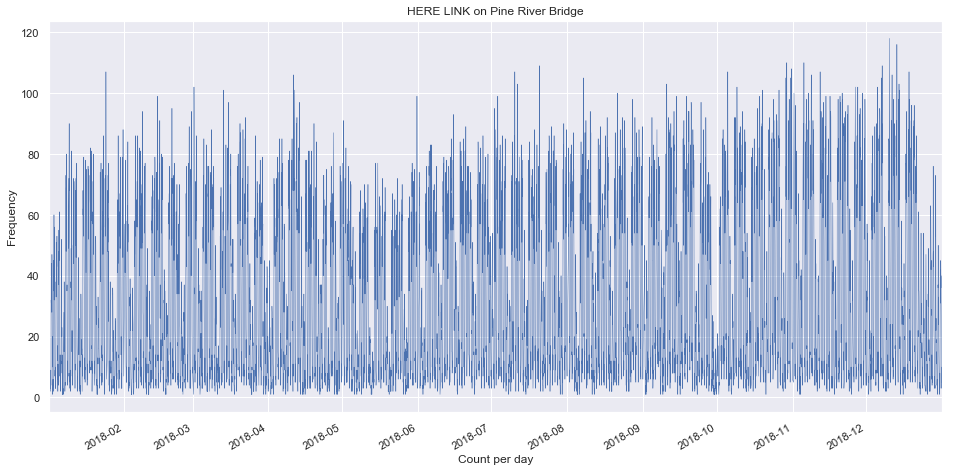

In [1967]:
#load HERE sample for link at Site 135970
data_repo = 'here_historic_links/'
here_links=pd.read_csv(data_repo+'HERE_DA_40074_00000.csv') 
#here_links.head() #show the format data

#assign weekday to dataset
here_links_rel_col = here_links[['DATE-TIME','EPOCH-60MIN','COUNT']] #save only the columns needed
here_links_rel_col['DATE-TIME']= pd.to_datetime(here_links_rel_col['DATE-TIME'],dayfirst=True) #set date/time column as time type
#here_links_rel_col=here_links_rel_col.set_index('DATE-TIME')

#set weekday names
here_links_rel_col['DATE-TIME'] = pd.to_datetime(here_links_rel_col['DATE-TIME'])
here_links_rel_col['day_of_week'] = here_links_rel_col['DATE-TIME'].dt.day_name()
#here_links_rel_col.dtypes

#show timeseries
here_links_rel_col_timeseries = here_links_rel_col.set_index('DATE-TIME') #set index
import seaborn as sns
sns.set(rc={'figure.figsize':(16, 8)})
here_links_rel_col_timeseries['COUNT'].plot(linewidth=0.5);
plt.title('HERE LINK on Pine River Bridge')
plt.xlabel('Count per day')
plt.ylabel('Frequency')

#### Above timeseries show nonstationarity, periodic fluctuations.
Lets investigate day variation and distribution. 

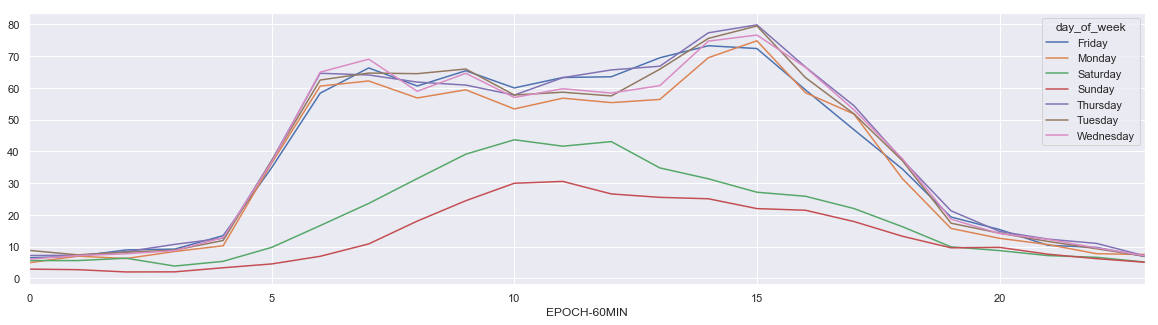

In [1968]:
#average day of week
here_links_rel_col.pivot_table(
    index = 'EPOCH-60MIN',
    columns ='day_of_week',
    values = 'COUNT',   aggfunc='mean', fill_value=0).plot(subplots=False, figsize=(20, 5), grid= True);

Expected typical distribution. Weekend does not follow bimodal, show maximum pentration rate at 10am -12pm.
Remove weekends and investigate only weekdays ast typical days. 

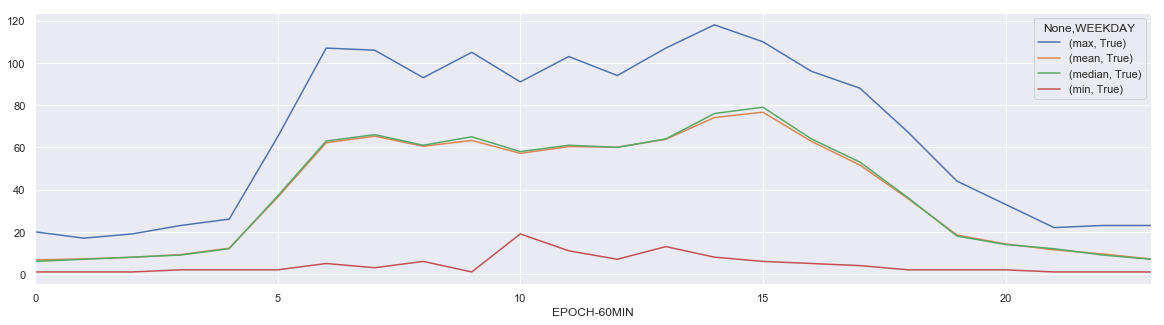

In [1969]:
# just weekdays statistics
here_links_rel_col['WEEKDAY']= ~here_links_rel_col['day_of_week'].str.contains('Saturday|Sunday', na=False) 
mask=~here_links_rel_col['day_of_week'].str.contains('Saturday|Sunday', na=False) 
here_links_rel_col_weekdays = here_links_rel_col.loc[mask] #just weekdays

here_links_rel_col_weekdays.pivot_table(
    index = 'EPOCH-60MIN',
    columns ='WEEKDAY',
    values = 'COUNT',   aggfunc=('max','median','mean','min'), fill_value=0).plot(subplots=False, figsize=(20, 5), grid= True);

### Law of large numbers theorm 
'average of results should reflect expected value when n(number of expirements) increase'

Shows variation in weekday. Low counts do not reflect what we expect to see.
However the median/average is representative and is a promising. Averaging large n removes outliers.

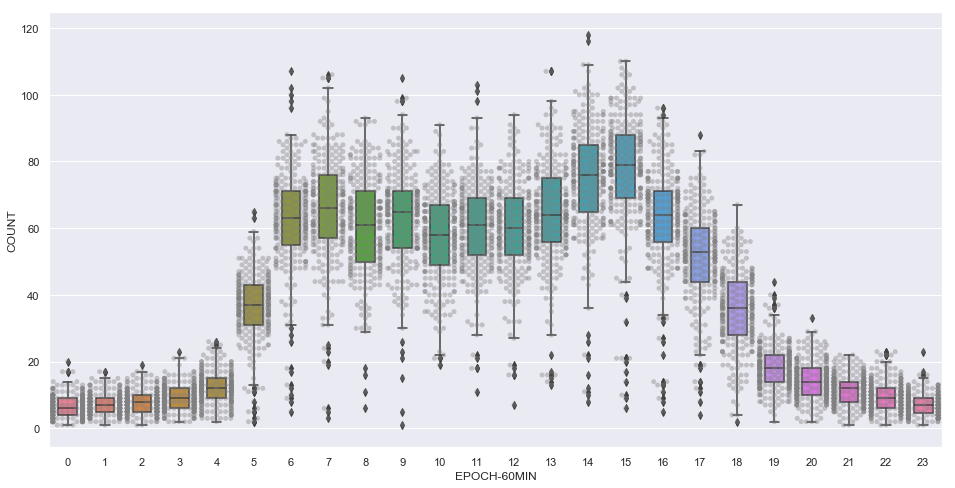

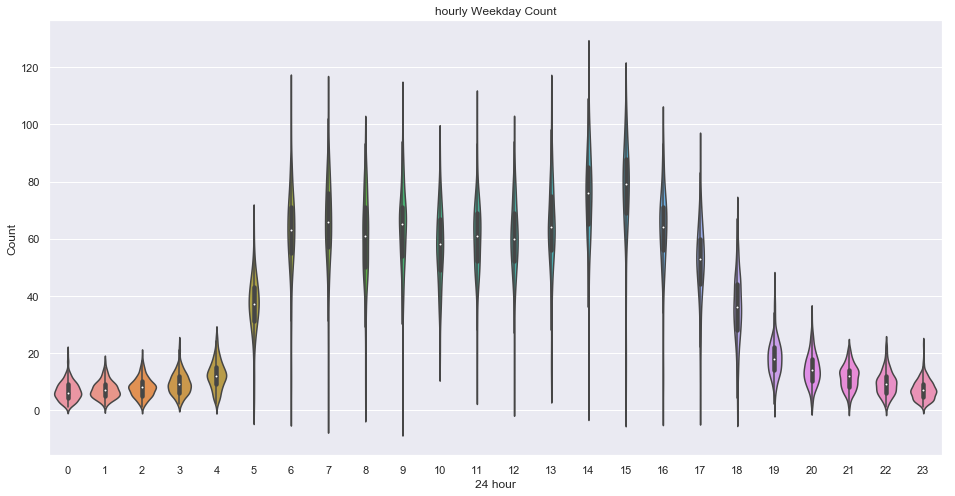

In [1573]:
#shows distribution on weekday count
bplot=sns.boxplot(y='COUNT', x='EPOCH-60MIN', 
                 data=here_links_rel_col_weekdays, 
                 width=0.5,
                 palette="husl")

# add swarmplot
bplot=sns.swarmplot(y='COUNT', x='EPOCH-60MIN',
              data=here_links_rel_col_weekdays, 
              color='grey',
              alpha=0.4)

# add violin plot
fig, axes = plt.subplots()
sns.violinplot(y='COUNT', x='EPOCH-60MIN',
              data=here_links_rel_col_weekdays, 
              alpha=0.4)
axes.set_title('hourly Weekday Count')
axes.set_xlabel('24 hour')
axes.set_ylabel('Count')

plt.show()

Distribution by hour - shows the large variance hours 5am - 6pm.

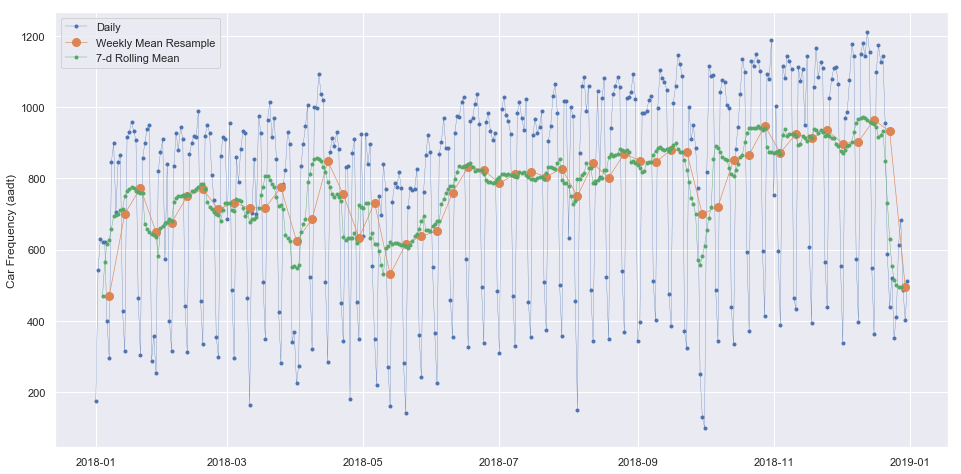

In [1520]:
#daily
here_links_rel_col_timeseries = here_links_rel_col.set_index('DATE-TIME') #set index

#sum to day
here_links_rel_col_timeseries_daily = here_links_rel_col_timeseries['COUNT'].resample('D').sum()

#resample to week
here_links_rel_col_timeseries_weekly = here_links_rel_col_timeseries_daily.resample('W').mean()

#Trends
#opsd_365d = here_links_rel_col_timeseries_daily.rolling(window=365, center=True, min_periods=365).mean()
opsd_7d = here_links_rel_col_timeseries_daily.rolling(7, center=True).mean()

start, end = '2018-01', '2018-12'
fig, ax = plt.subplots()
ax.plot(here_links_rel_col_timeseries_daily.loc[start:end],
        marker='.', linestyle='-', linewidth=0.3, label='Daily')
ax.plot(here_links_rel_col_timeseries_weekly.loc[start:end],
        marker='o', markersize=8, linewidth=0.6, linestyle='-', label='Weekly Mean Resample')
ax.plot(opsd_7d ,marker='.', linestyle='-', linewidth=0.4,label='7-d Rolling Mean')
label='Trend (365-d Rolling Mean)'

ax.set_ylabel('Car Frequency (aadt)')
ax.legend();    


### Trends
We can see that the weekly mean time series is smoother than the daily time series because higher frequency variability has been averaged out in the resampling. 

We can see that data points in the rolling mean time series have the same spacing as the daily data, but the curve is smoother because higher frequency variability has been averaged out. In the rolling mean time series, the peaks and troughs tend to align closely with the peaks and troughs of the daily time series. In contrast, the peaks and troughs in the weekly resampled time series are less closely aligned with the daily time series, since the resampled time series is at a coarser granularity.

#### Note: troughs reflective of public holidays.

Results
Here weekday aadt: 923
Here vs aadt: 1.2 %


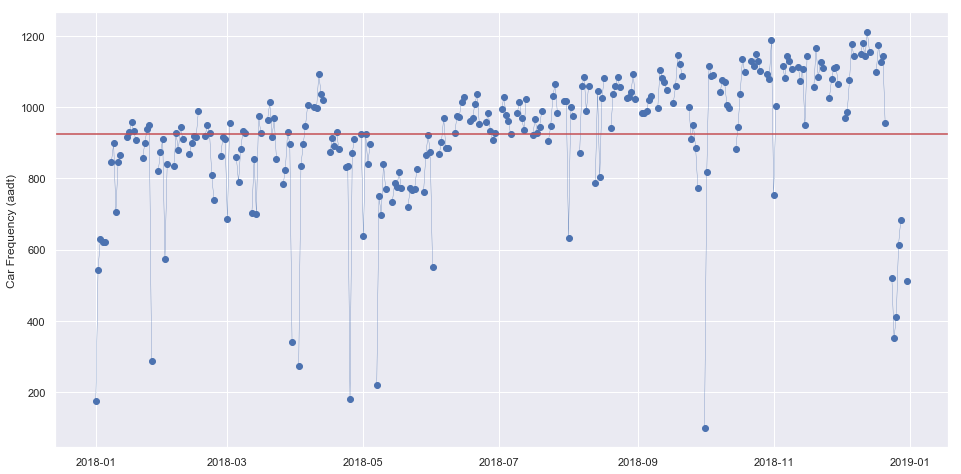

In [1541]:
#Remove the above weekends
here_links_rel_col_weekdays_timeseries = here_links_rel_col_weekdays.set_index('DATE-TIME') #set index
here_weekday_sum = here_links_rel_col_weekdays_timeseries['COUNT'].resample('D').sum()
here_weekday_sum =here_weekday_sum.replace(0, np.NaN)

#aadt
here_weekday_aadt = int(here_weekday_sum.mean()) 
here_weekday_aadt

fig, ax = plt.subplots()
ax.plot(here_weekday_sum,
        marker='o', linestyle='-', linewidth=0.3, label='Weekdays')
ax.axhline(y=here_weekday_aadt, color='r', linestyle='-')
ax.set_ylabel('Car Frequency (aadt)')

# Derived aadt 
#Compare against actuals
aadt_loops = 77905  # aadtSegmentAnalysisReportSummarys-7467981069708955029.pdf
print ('Results')
print('Here weekday aadt: ' +str(here_weekday_aadt))
print('Here vs aadt: '+str(round(here_weekday_aadt/aadt_loops *100,1)) + ' %')

### Variance

#### Given a understading of a site with large count, lets investigate a extremely small count site.
Site 120779 - MIVA ROAD	 with aadt of 24.

In [1361]:
aadt_2018_gdf_sort= aadt_2018_gdf.sort_values(by='AADT', ascending=True) #sort lowest aadt values
lowestlimit = 30

# Size limitation displaying over 1000 points
lons= lowest_aadt_2018_gdf_sort['LONGITUDE'][0:lowestlimit].values.tolist()
lats= lowest_aadt_2018_gdf_sort['LATITUDE'][0:lowestlimit].values.tolist()

site_selected =aadt_2018_gdf_sort[19:20] #this site is selected 
lons= site_selected['LONGITUDE'].values.tolist()
lats= site_selected['LATITUDE'].values.tolist()

fig = plt.figure(figsize=(8, 8))    #This is missing in your code.
plt.plot(lons, lats, 'b.', markersize = 30)
#And after this call the funtion:
mplleaflet.display(fig=fig,)
#site_selected

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


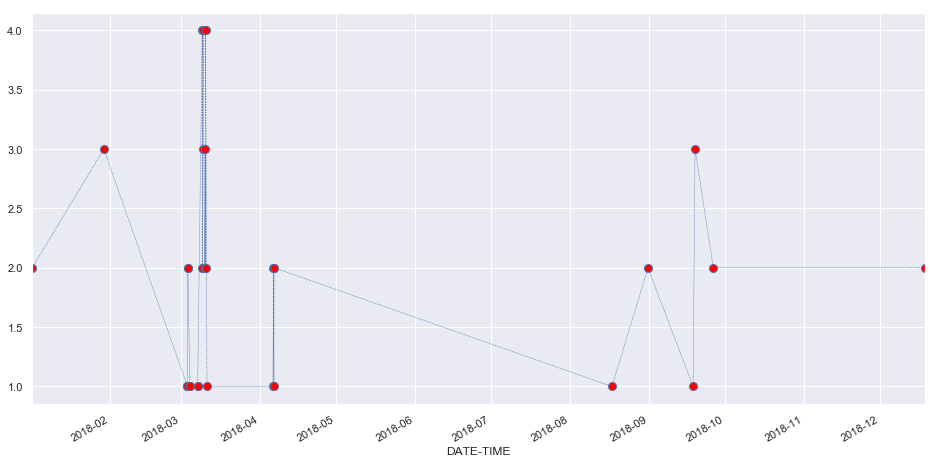

In [1970]:
#load here link
data_repo = 'here_historic_links/'
here_links=pd.read_csv(data_repo+'HERE_DA_40137_00000.csv') 
here_links_rel_col = here_links[['DATE-TIME','EPOCH-60MIN','COUNT']] #save only the columns needed
here_links_rel_col['DATE-TIME']= pd.to_datetime(here_links_rel_col['DATE-TIME'],dayfirst=True) #set date/time column as time type

#set weekday names
here_links_rel_col['DATE-TIME'] = pd.to_datetime(here_links_rel_col['DATE-TIME'])
here_links_rel_col['day_of_week'] = here_links_rel_col['DATE-TIME'].dt.day_name()
#here_links_rel_col.tail()

#show timeseries
here_links_rel_col_timeseries = here_links_rel_col.set_index('DATE-TIME') #set index
import seaborn as sns
sns.set(rc={'figure.figsize':(16, 8)})
here_links_rel_col_timeseries['COUNT'].plot(linewidth=0.5,marker='o',linestyle='dashed',label="toto",markersize=8,markerfacecolor='red');

#### Resample - upsampling ( irregularity spaced time series)

It is often useful to resample our time series data to a lower or higher frequency. Resampling to a lower frequency (downsampling, as shown previously) usually involves an aggregation operation — for example, computing monthly count totals from daily data - for large couting sites.

This site (low count) requires resampling to a higher frequency (upsampling) is less common and often involves interpolation or other data filling method — for example, interpolating hourly count data to 10 minute intervals for input to a scientific model.
*note: Future works, for irregular spaced time series explore constructing a Kalman filter.

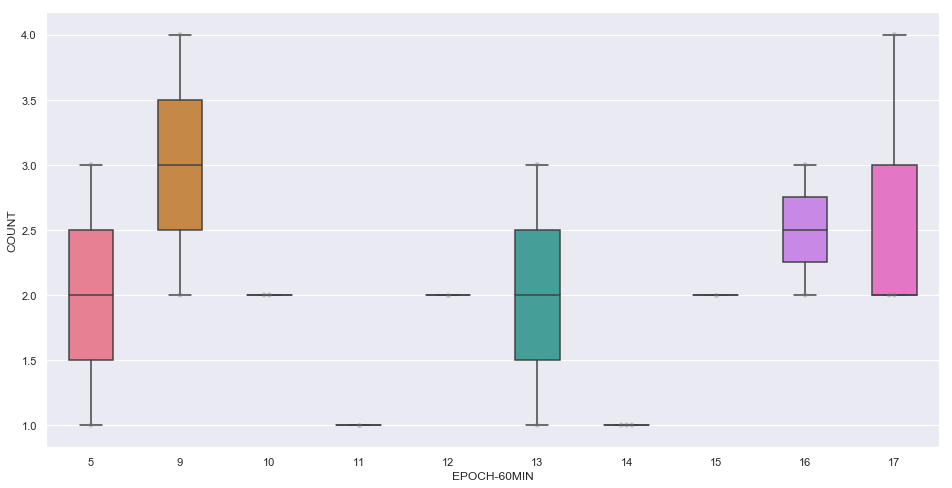

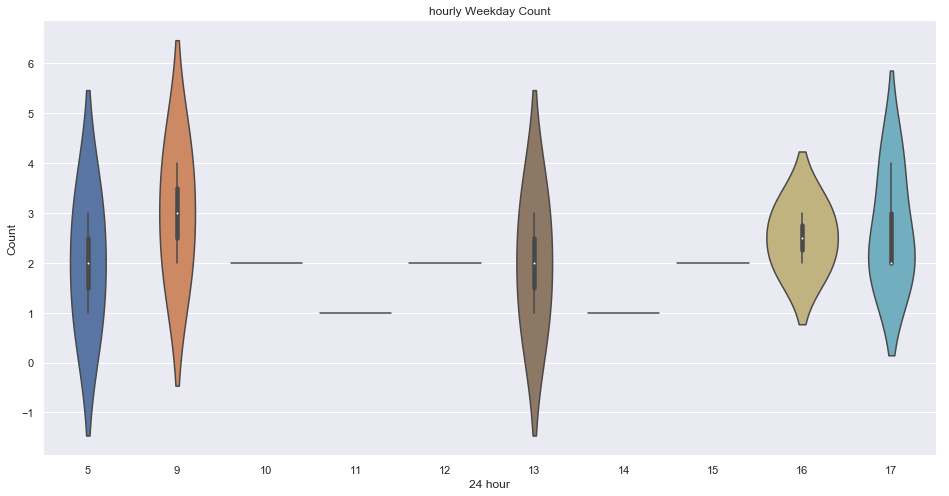

In [1971]:
#lets have a look at the breakdown by weekdays hours.
# just weekdays statistics
here_links_rel_col['WEEKDAY']= ~here_links_rel_col['day_of_week'].str.contains('Saturday|Sunday', na=False) 
mask=~here_links_rel_col['day_of_week'].str.contains('Saturday|Sunday', na=False) 
here_links_rel_col_weekdays = here_links_rel_col.loc[mask] #just weekdays

#shows distribution on weekday count
bplot=sns.boxplot(y='COUNT', x='EPOCH-60MIN', 
                 data=here_links_rel_col_weekdays, 
                 width=0.5,
                 palette="husl")

# add swarmplot
bplot=sns.swarmplot(y='COUNT', x='EPOCH-60MIN',
              data=here_links_rel_col_weekdays, 
              color='grey',
              alpha=0.4)

# add violin plot
fig, axes = plt.subplots()
sns.violinplot(y='COUNT', x='EPOCH-60MIN',
              data=here_links_rel_col_weekdays, 
              alpha=0.4)
axes.set_title('hourly Weekday Count')
axes.set_xlabel('24 hour')
axes.set_ylabel('Count')

plt.show()


In [1377]:
# shows most samples are collected at 5am,9am,1pm,4pm,5pm
here_links_rel_col_weekdays_by_hour_avg_statistic =here_links_rel_col_weekdays.groupby(['EPOCH-60MIN'])['DATE-TIME','COUNT'].mean()
here_links_rel_col_weekdays_by_hour_avg_statistic

,COUNT
EPOCH-60MIN,
5,2.000000
9,3.000000
10,2.000000
11,1.000000
12,2.000000
13,2.000000
14,1.000000
15,2.000000
16,2.500000


In [1560]:
#Calculate the average weekday count - derived weekday
aadt_here_link=int(round(here_links_rel_col_weekdays_by_hour_avg_statistic.sum(),-1)) #nearest car
aadt_here_link =here_links_rel_col_weekdays_by_hour_avg_statistic.mean()/365
aadt_here_link= round(aadt_here_link['COUNT'],2)

#Compare against actuals
aadt_loops = 24  # aadtSegmentAnalysisReportSummarys-7467981069708955029.pdf
#print(str(round(aadt_here_link/aadt_loops *100,1)) + ' %')

print ('Results')
print('Here aadt: ' +str(aadt_here_link))
print('Here vs aadt: '+str(round(aadt_here_link/aadt_loops *100,3)) + ' %')

Results
Here aadt: 0.01
Here vs aadt: 0.042 %


#### As this is not there is not enough data - unable to make a provide confident sample statistics. 

## Scaling metrics and Bias
For scalabity any link with zero count will be not included.

In [1952]:
#resample to aadt values to compare against actuals
def aadt_here_links_statistics(here_file_name, siteID):
    '''Takes a here link and calcuates statistical values for aadt'''

    data_repo = 'here_historic_links/'
    #load HERE sample for link at Site 135970
    here_links=pd.read_csv(data_repo+here_file_name) 
    #here_links.head() #show the format data

    #assign weekday to dataset
    here_links_rel_col = here_links[['DATE-TIME','EPOCH-60MIN','COUNT']] #save only the columns needed
    here_links_rel_col['DATE-TIME']= pd.to_datetime(here_links_rel_col['DATE-TIME'],dayfirst=True) #set date/time column as time type
    #here_links_rel_col=here_links_rel_col.set_index('DATE-TIME')

    #set weekday names
    here_links_rel_col['DATE-TIME'] = pd.to_datetime(here_links_rel_col['DATE-TIME'])
    here_links_rel_col['day_of_week'] = here_links_rel_col['DATE-TIME'].dt.day_name()

    #set index
    here_links_rel_col_timeseries = here_links_rel_col.set_index('DATE-TIME') 
    #set weekdays
    here_links_rel_col['WEEKDAY']= ~here_links_rel_col['day_of_week'].str.contains('Saturday|Sunday', na=False) 
    mask=~here_links_rel_col['day_of_week'].str.contains('Saturday|Sunday', na=False) 
    here_links_rel_col_weekdays = here_links_rel_col.loc[mask] #just weekdays

    #sum to day
    here_links_rel_col_timeseries_daily = here_links_rel_col_timeseries['COUNT'].resample('D').sum()

    #resample to week
    here_links_rel_col_timeseries_weekly = here_links_rel_col_timeseries_daily.resample('W').mean()

    #Trends
    here_links_rel_col_timeseries_7d_rolling = here_links_rel_col_timeseries_daily.rolling(7, center=True).mean()\

    #Remove the above weekends
    here_links_rel_col_weekdays_timeseries = here_links_rel_col_weekdays.set_index('DATE-TIME') #set index
    here_weekday_sum = here_links_rel_col_weekdays_timeseries['COUNT'].resample('D').sum()
    #here_weekday_sum =here_weekday_sum.replace(0, np.NaN)

    #aadt
    average_weekday_mean = int(here_weekday_sum.mean()) 
    average_weekday_max =  int(here_weekday_sum.max())
    average_weekday_min = int(here_weekday_sum.min())
    average_weekday_median = int(here_weekday_sum.median())

    fig, ax = plt.subplots()
    ax.plot(here_weekday_sum,
            marker='o', linestyle='-', linewidth=0.3, label='Weekdays')
    ax.axhline(y=average_weekday_mean, color='r', linestyle='-')
    ax.set_ylabel('Car Frequency (aadt)')
    plt.title('HERE LINK on '+ siteID)
    

    # # Derived aadt 
    # #Compare against actuals
    # aadt_loops = 3382  # aadtSegmentAnalysisReportSummarys-7467981069708955029.pdf
    # print ('Results')
    # print('Here weekday aadt: ' +str(average_weekday_mean))
    # print('Here vs aadt: '+str(round(average_weekday_mean/aadt_loops *100,1)) + ' %')

    # start, end = '2018-01', '2018-12'
    # fig, ax = plt.subplots()
    # ax.plot(here_links_rel_col_timeseries_daily.loc[start:end],
    #         marker='.', linestyle='-', linewidth=0.3, label='Daily')
    # ax.plot(here_links_rel_col_timeseries_weekly.loc[start:end],
    #         marker='o', markersize=8, linewidth=0.6, linestyle='-', label='Weekly Mean Resample')
    # ax.plot(here_links_rel_col_timeseries_7d_rolling ,marker='.', linestyle='-', linewidth=0.4,label='7-d Rolling Mean')
    # label='Trend (365-d Rolling Mean)'

    # ax.set_ylabel('Car Frequency (aadt)')
    # ax.legend();    

    #plot timeseries
    # import seaborn as sns
    # sns.set(rc={'figure.figsize':(16, 8)})
    # here_links_rel_col_timeseries['COUNT'].plot(linewidth=0.5);
    # plt.title('HERE LINK on Pine River Bridge')
    # plt.xlabel('Count per day')
    # plt.ylabel('Frequency')

    # plot week break down by day
    # here_links_rel_col.pivot_table(
    #     index = 'EPOCH-60MIN',
    #     columns ='day_of_week',
    #     values = 'COUNT',   aggfunc='mean', fill_value=0).plot(subplots=False, figsize=(20, 5), grid= True);


    #plot weekday range
    # here_links_rel_col_weekdays.pivot_table(
    #     index = 'EPOCH-60MIN',
    #     columns ='WEEKDAY',
    #     values = 'COUNT',   aggfunc=('max','median','mean','min'), fill_value=0).plot(subplots=False, figsize=(20, 5), grid= True);


    #plot distribution on weekday count
    # bplot=sns.boxplot(y='COUNT', x='EPOCH-60MIN', 
    #                  data=here_links_rel_col_weekdays, 
    #                  width=0.5,
    #                  palette="husl")

    # # add swarmplot
    # bplot=sns.swarmplot(y='COUNT', x='EPOCH-60MIN',
    #               data=here_links_rel_col_weekdays, 
    #               color='grey',
    #               alpha=0.4)

    # # add violin plot
    # fig, axes = plt.subplots()
    # sns.violinplot(y='COUNT', x='EPOCH-60MIN',
    #               data=here_links_rel_col_weekdays, 
    #               alpha=0.4)
    # axes.set_title('hourly Weekday Count')
    # axes.set_xlabel('24 hour')
    # axes.set_ylabel('Count')

    # plt.show()

    return average_weekday_mean, average_weekday_max, average_weekday_min,average_weekday_median

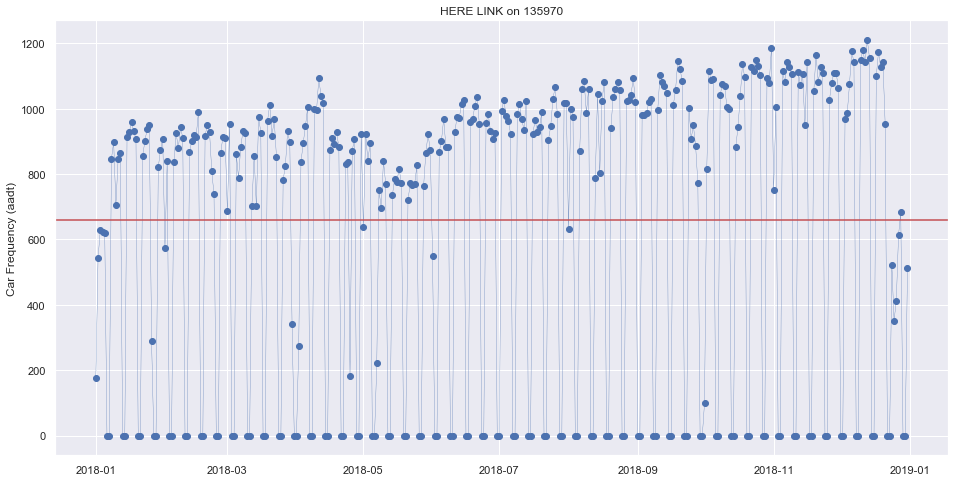

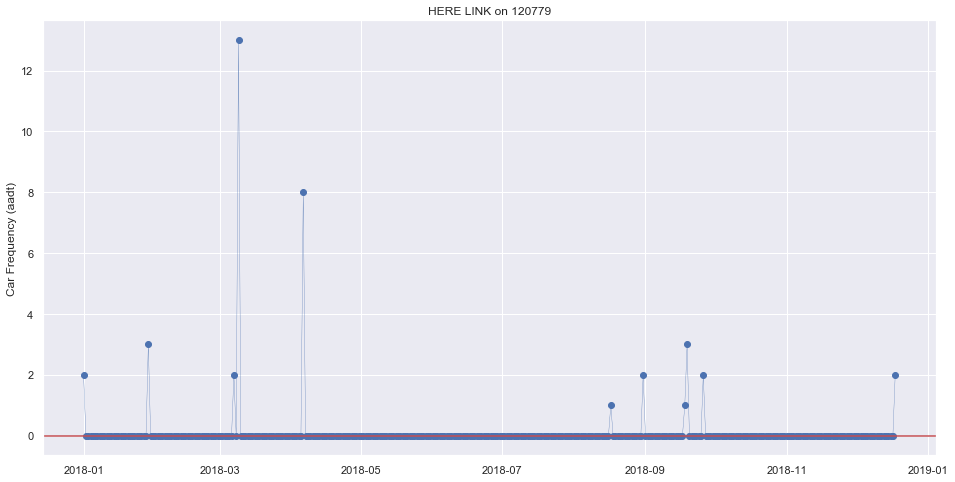

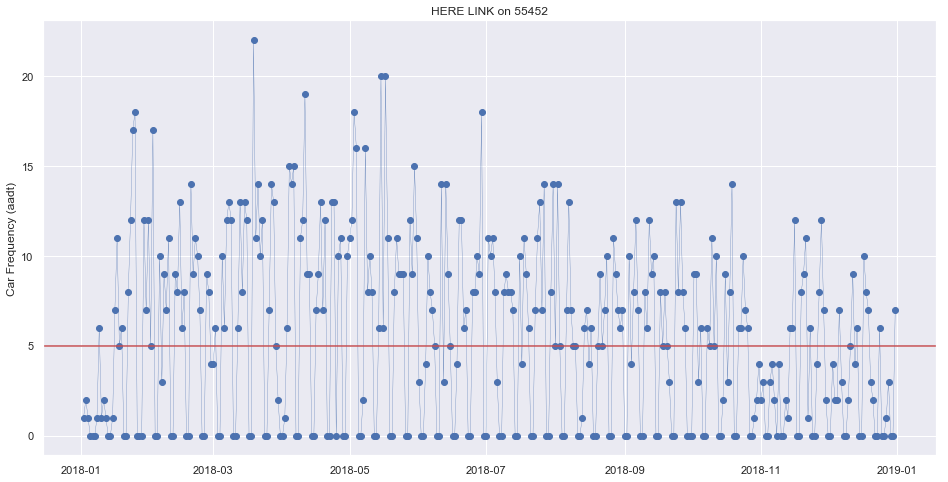

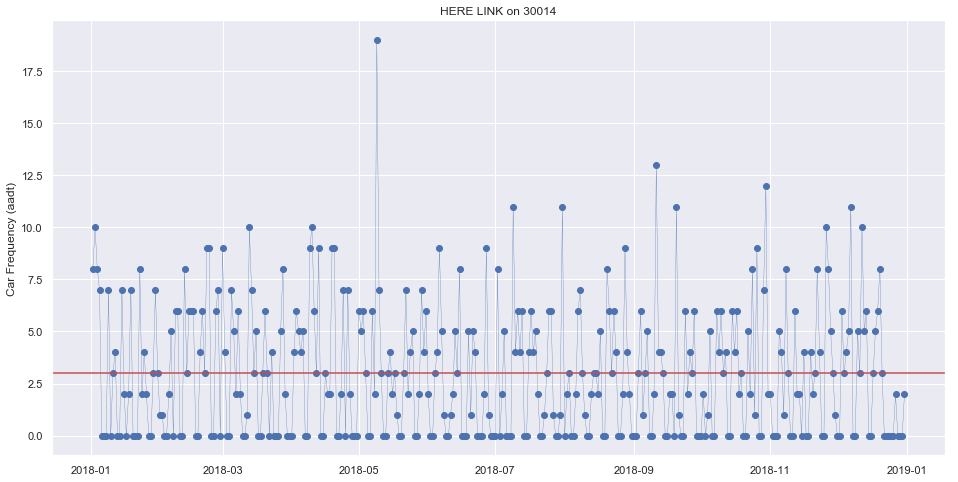

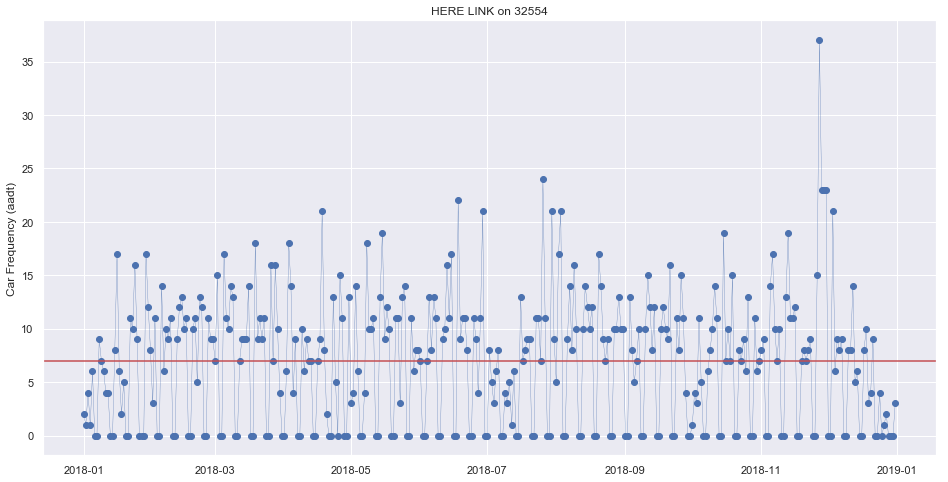

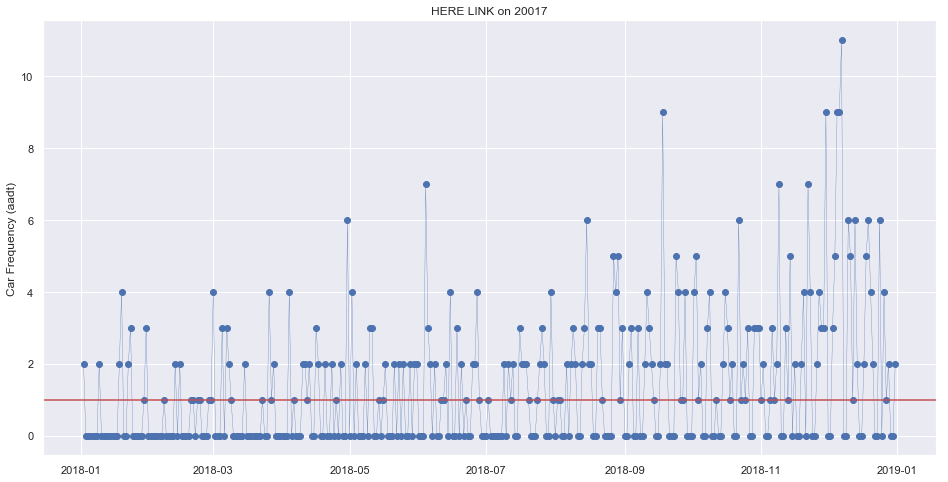

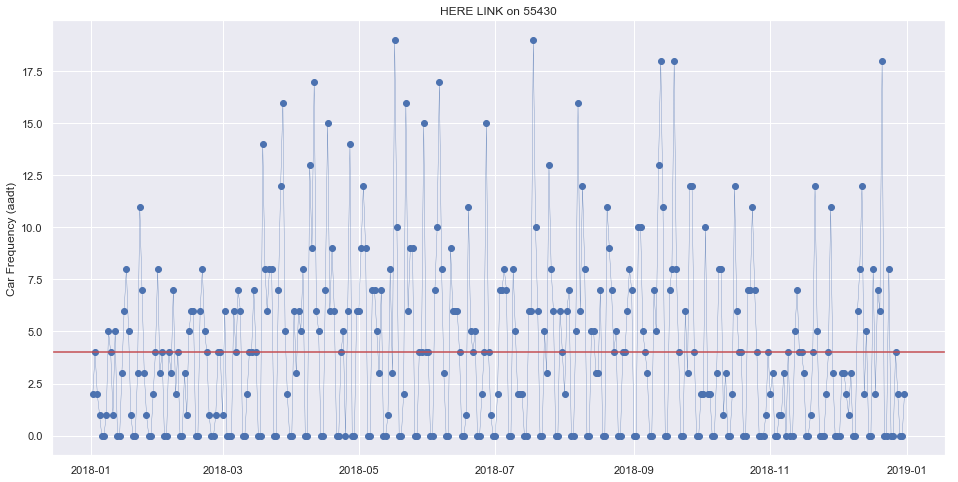

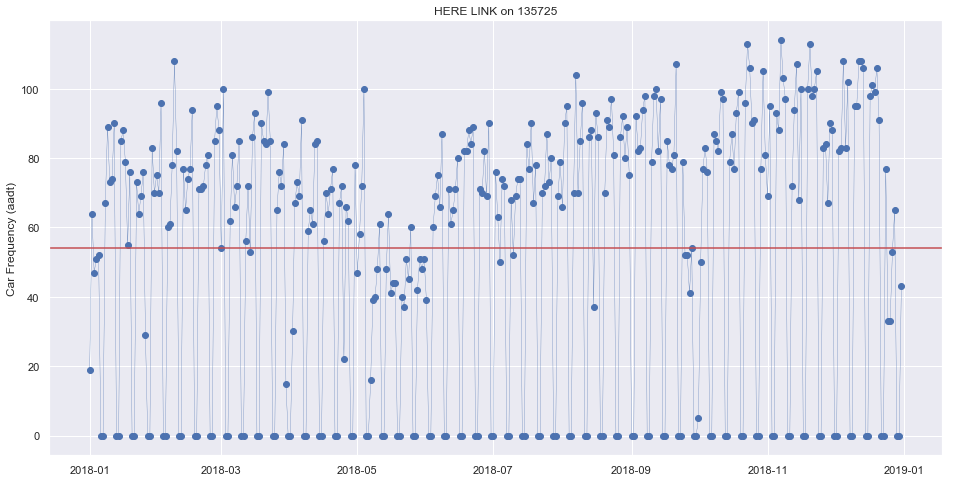

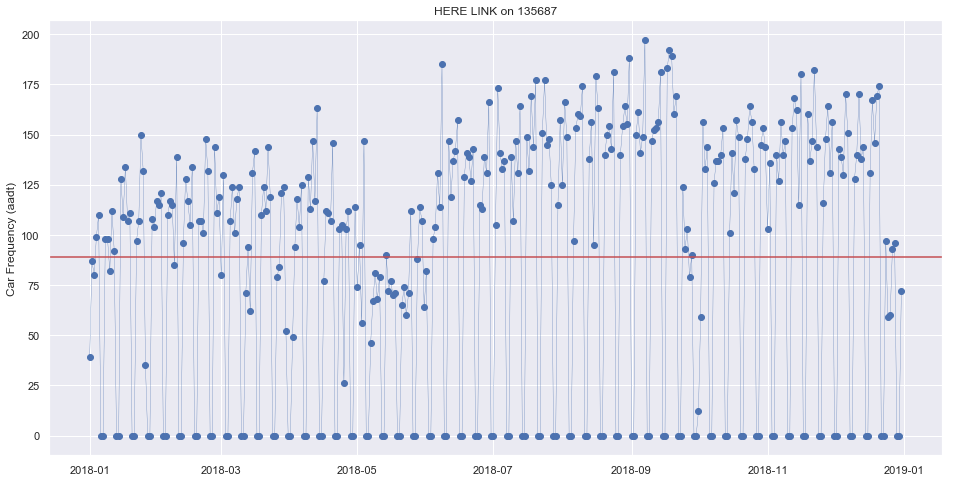

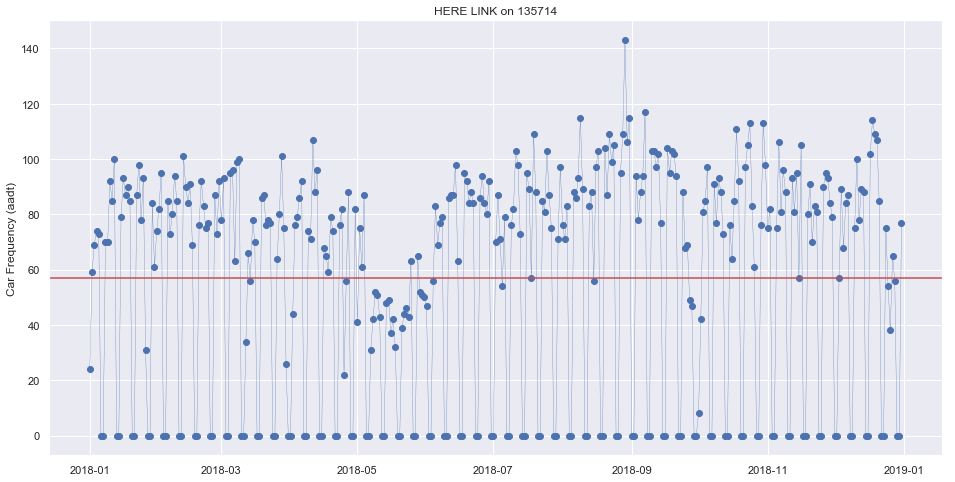

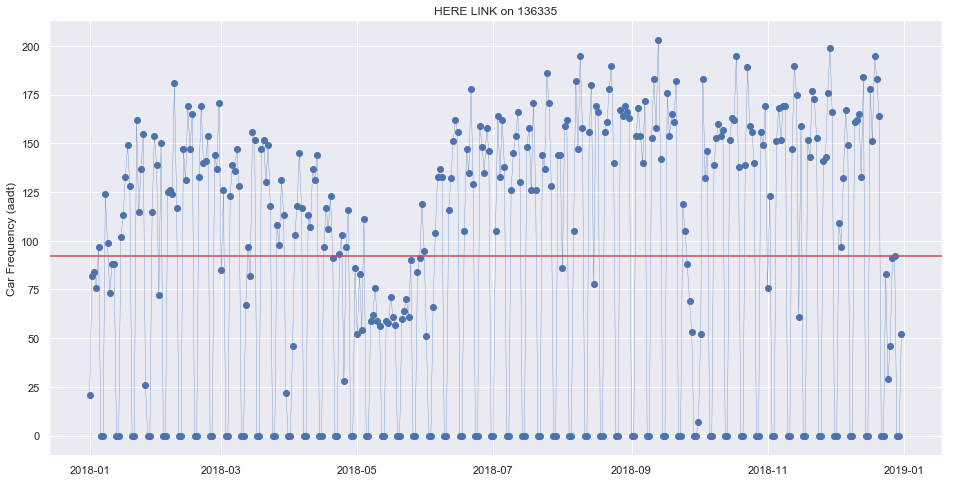

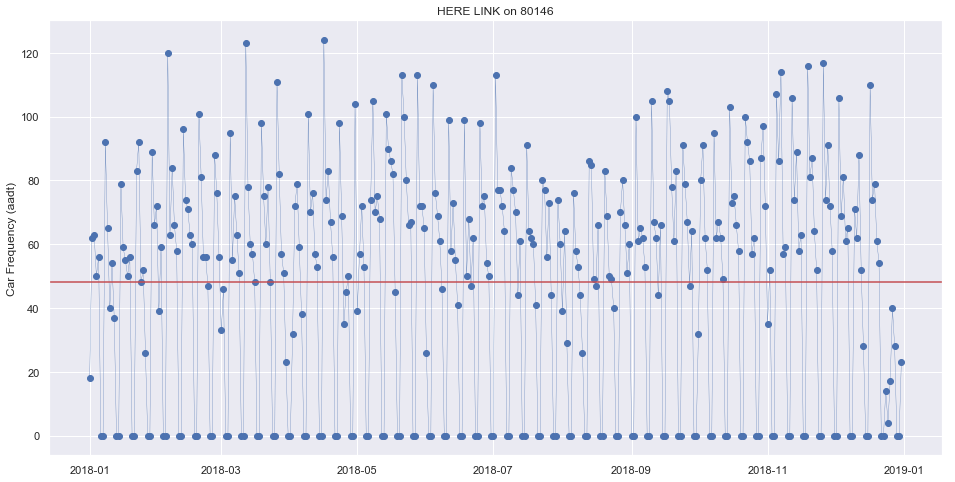

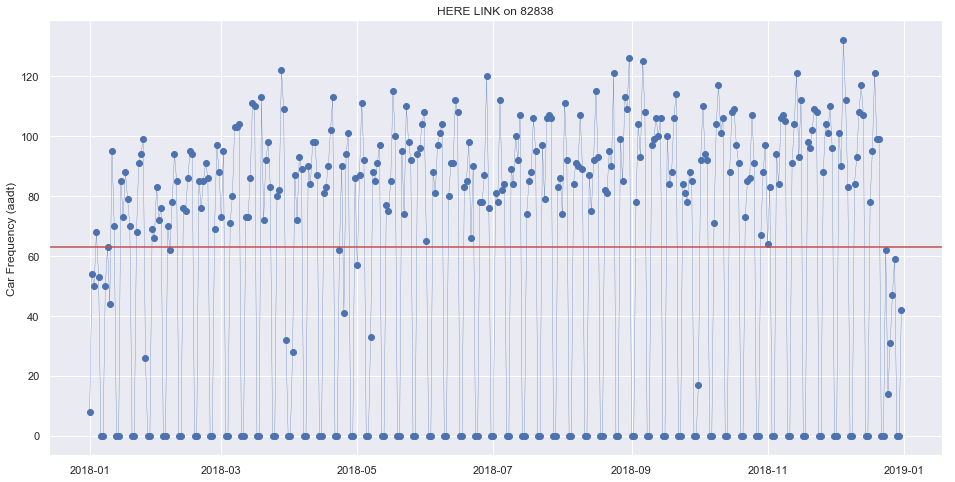

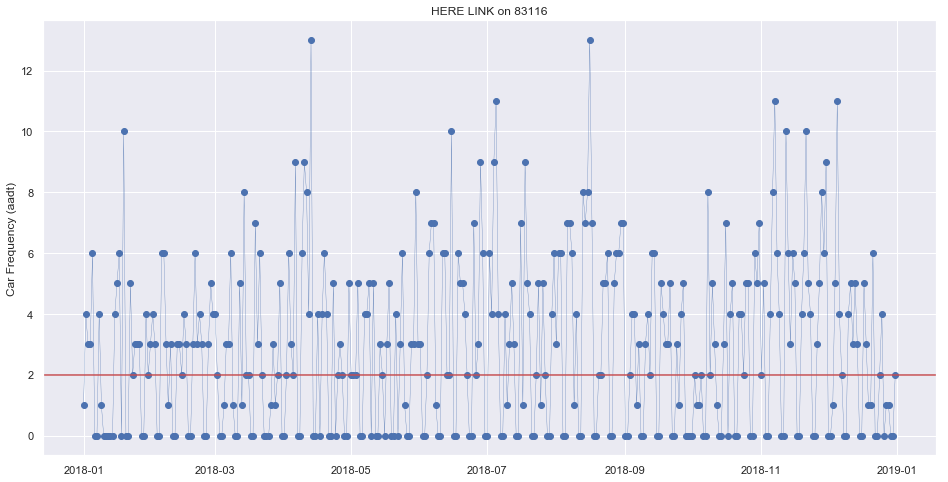

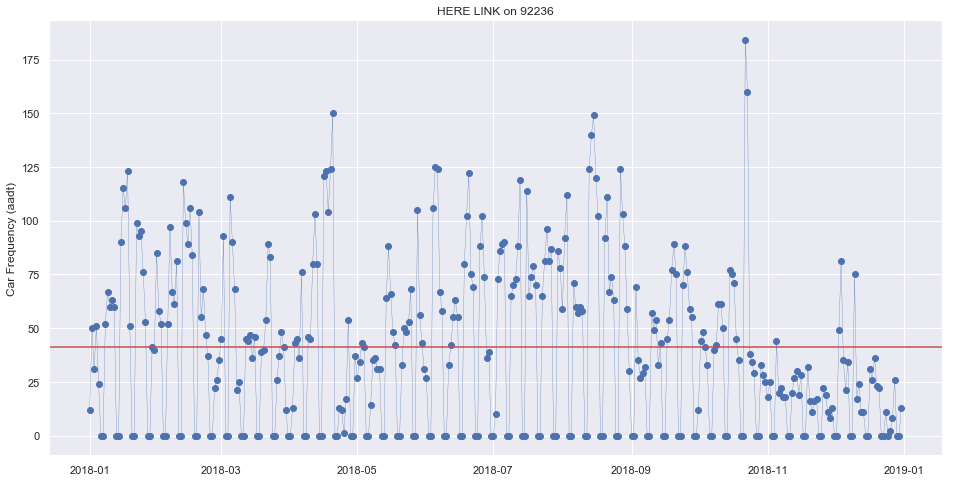

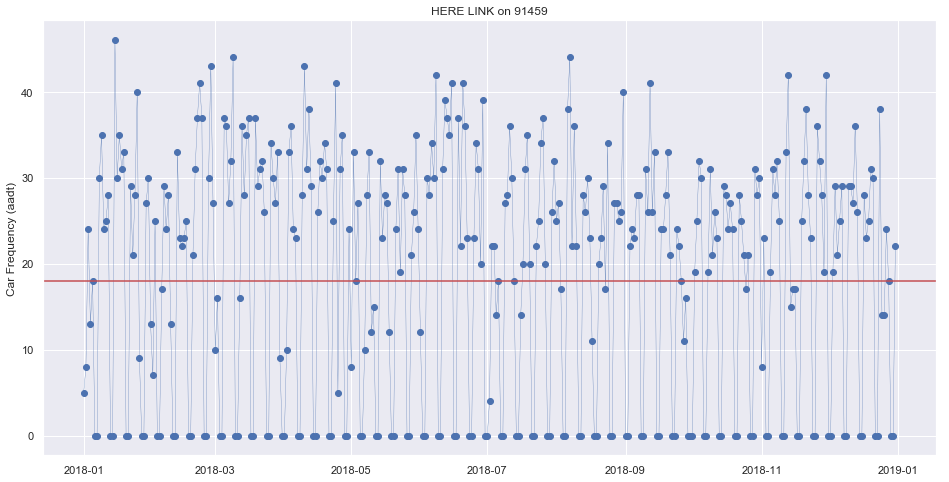

In [1953]:
#load datasets
list_of_files = ('HERE_DA_40074_00000.csv','HERE_DA_40137_00000.csv','HERE_DA_40222_00000.csv','HERE_DA_40215_00000.csv',
                 'HERE_DA_40218_00000.csv','HERE_DA_40219_00000.csv','HERE_DA_40221_00000.csv','HERE_DA_40274_00000.csv',
                 'HERE_DA_40272_00000.csv','HERE_DA_40271_00000.csv','HERE_DA_40270_00000.csv','HERE_DA_40342_00000.csv',
                 'HERE_DA_40343_00000.csv','HERE_DA_40344_00000.csv','HERE_DA_40346_00000.csv','HERE_DA_40347_00000.csv'
                 )

site_id_ordered = ['135970','120779','55452','30014','32554','20017','55430','135725','135687','135714','136335','80146','82838','83116','92236','91459']
site_aadt_ordered = [155916,24,2019,1533,1309,7441,4802,21610,31308,28321,8122,3382,9892,3328,4403,7311]


results_data = pd.DataFrame([])
i=0
for link in list_of_files:
    ink_mean,link_max,link_min,link_med =  aadt_here_links_statistics(link,site_id_ordered[i])
    results_data = results_data.append(pd.DataFrame({'site': int(site_id_ordered[i]),'aadt_actual': site_aadt_ordered[i],'aadt_mean_here': ink_mean,  'aadt_max_here': link_max, 'aadt_min_here': link_min, 'aadt_median_here':link_med,'sample_percentage': round((ink_mean/site_aadt_ordered[i])*100,1)}, index=[i]), ignore_index=True)
    i+=1

#### *Note Site: 20017 ( East Gympie) has a compartively large aadt of 7441 and here link return little no average value and Site: 136335 (Brisbane City) and Site:80146 (Coppebella) has the inverse relationship.  * Heavy vehicle routes?

In [1986]:
#view specfic site
site_qaqc = aadt_2018.loc[aadt_2018['SITE_ID'] == 20017]
lons= site_qaqc['LONGITUDE'].values.tolist()
lats= site_qaqc['LATITUDE'].values.tolist()

#view all sites
results_data=aadt_2018[aadt_2018['SITE_ID'].isin(site_id_ordered)]
lons= results_data['LONGITUDE'].values.tolist()
lats= results_data['LATITUDE'].values.tolist()


#site_qaqc # for data
fig = plt.figure(figsize=(8, 8))    #Thisis missing in your code.
plt.plot(lons, lats, 'r.', markersize = 20)
#And after this call the funtion:
mplleaflet.display(fig=fig,)

In [1902]:
## Remove addt_here values that come back as zero - can not use these
results_data_nozeros = results_data[~(results_data['aadt_mean_here'] == 0)]
#Rank
results_data_nozeros['actual_rank'] = results_data_nozeros['aadt_actual'].rank(ascending=False).astype(int)
results_data_nozeros['here_rank'] = results_data_nozeros['aadt_mean_here'].rank(ascending=False).astype(int)
results_data_nozeros

,site,aadt_actual,aadt_mean_here,aadt_max_here,aadt_min_here,aadt_median_here,sample_percentage,actual_rank,here_rank
0,135970,155916,660,1210,0,884,0.4,1,1
2,55452,2019,5,22,0,6,0.2,13,11
3,30014,1533,3,19,0,2,0.2,14,13
4,32554,1309,7,37,0,8,0.5,15,10
5,20017,7441,1,11,0,0,0.0,7,15
6,55430,4802,4,19,0,4,0.1,9,12
7,135725,21610,54,114,0,69,0.2,4,6
8,135687,31308,89,197,0,108,0.3,2,3
9,135714,28321,57,143,0,74,0.2,3,5
10,136335,8122,92,203,0,113,1.1,6,2


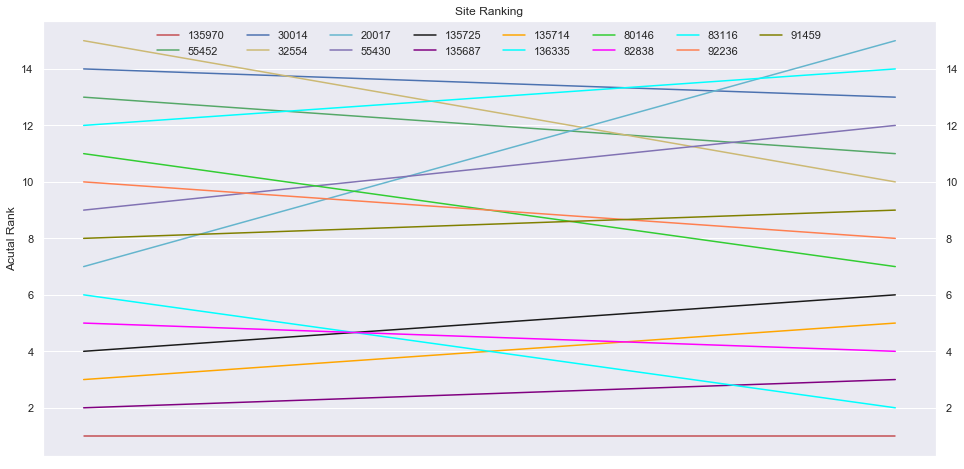

In [1950]:
fig, ax1 = plt.subplots()
x=(1, 2)
color = ['r', 'g', 'b', 'y','c', 'm', 'k', 'purple', 'orange', 'cyan','limegreen',
         'magenta','aqua','coral', 'olive', 'brown', 'chartreuse','fuchsia']
list_id_site = results_data_nozeros['site'].tolist()

i=0
for index, row in results_data_nozeros.iterrows():
    siteId = int(row['site'])
    y = int(row['actual_rank']) , int(row['here_rank']) 
    #ax1.plot(x, y, 'b-')
    ax1.plot(x, y, color[i], label = list_id_site[i])
    i+=1

ax1.legend(loc='upper center', frameon=False, ncol=8)
ax1.set_title('Site Ranking')
ax1.set_ylabel('Acutal Rank')  

plt.tick_params(axis='y', which='both', labelleft='on', labelright='on')
plt.gca().axes.get_xaxis().set_visible(False)

# left axis is Actual ranking - right axis is HERE link rankings..... See no linear nature 20017 and 135714


### Conclusion:
##### Non linear relationship between aadt sites from TMR and HERE samples (penetration rates ranges from 0 - 1.4% and ranking differences).

From this initial investigation large n sample links (law of large numbers) indicate a distribution that what we would expect to see. Further investigation maybe required to how similar this is to actuals. If this is the case - metrics such as speed/time maybe inferred with confidence. (Determining what size n is required needs further investigation).
- Required sample size for testing. (experience, target variance, power of statisticasl test, and confidence interval)


However aadt values - scalabilty giving a constant(x) are not practical given the proved non linear relationship between Aadt and HERE. Futher bias and variance are shown in both large and small counts.
- For estimated mean (on sample size ) we should use, $\frac{\sigma}{\sqrt{n}}$ if sample are i.i.d - Independent identically distributed random variables.


###### Future works
1) Recommend further studies into the relationship between type and vehicles and road (i.e Similar count two links - One with a approved route for hwy and one restricted).

2) Automation to extract all links and process. 
Started code and found 1) links change and will not always get a result. 2) Likely to see similar results as presented.

3) Further analysis by hour break down with aadt.